# motion estimation figure2








In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# %matplotlib widget

In [3]:
from pathlib import Path

import spikeinterface.full as si

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12)

from probeinterface.plotting import plot_probe


from spikeinterface.sortingcomponents import detect_peaks
from spikeinterface.sortingcomponents import localize_peaks

In [4]:
# local folder
base_folder = Path('/media/e4/data1/CorinnasData/raw_data/bird1')

name = 'raw_awake'
dataset_folder = base_folder / name
preprocess_folder = base_folder / f'{name}_preprocessed'

peak_folder = base_folder / f'{name}_peaks'

peak_folder.mkdir(exist_ok=True)

In [4]:
dataset_folder.is_dir()

True

In [5]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=30,
    chunk_memory='10M',
    progress_bar=True,
)

In [6]:
# read the file
rec = si.read_spikeglx(dataset_folder, stream_id='imec0.ap')
rec

SpikeGLXRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 3881.358s

(-50.0, 400.0)

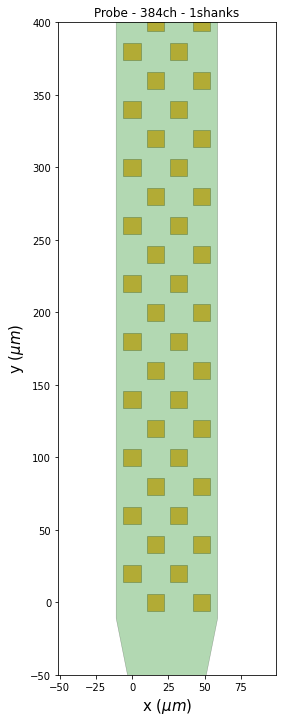

In [7]:
fig, ax = plt.subplots()

plot_probe(rec.get_probe(), ax=ax)
ax.set_ylim(-50, 400)

# TODO plot how peaks per channel

## preprocess

This take 4 min for 30min of signals

In [8]:
rec_filtered = si.bandpass_filter(rec, freq_min=300., freq_max=6000.)
rec_preprocessed = si.common_reference(rec_filtered, reference='local',
                                       local_radius=(50, 100), operator='median')
rec_preprocessed.save(folder=preprocess_folder, **job_kwargs)

write_binary_recording with n_jobs 40  chunk_size 13020


write_binary_recording: 100%|██████████| 8944/8944 [57:23<00:00,  2.60it/s]   


BinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 3881.358s
  file_paths: ['/media/e4/data1/CorinnasData/raw_data/bird1/raw_awake_preprocessed/traces_cached_seg0.raw']

In [8]:
# load back
rec_preprocessed = si.load_extractor(preprocess_folder)
rec_preprocessed

BinaryRecordingExtractor: 384 channels - 1 segments - 30.0kHz - 3881.358s
  file_paths: ['/media/e4/data1/CorinnasData/raw_data/bird1/raw_awake_preprocessed/traces_cached_seg0.raw']

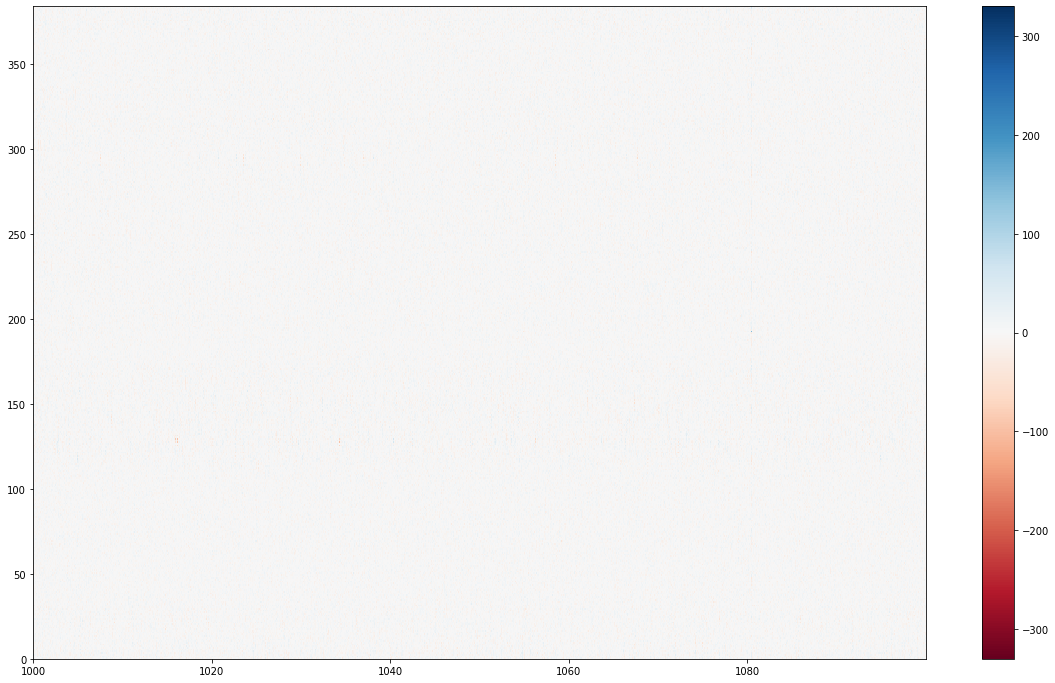

In [10]:
fig, ax = plt.subplots()
si.plot_timeseries(rec_preprocessed,
                   time_range=(1000, 1100),
                   # channel_ids = rec_preprocessed.channel_ids[60:70],
                  ax=ax)

## estimate noise

(array([  1.,   0.,   0., 265.,   0.,   0., 114.,   0.,   0.,   4.]),
 array([10.424389, 11.466827, 12.509267, 13.551705, 14.594145, 15.636583,
        16.679022, 17.72146 , 18.7639  , 19.80634 , 20.848778],
       dtype=float32),
 <BarContainer object of 10 artists>)

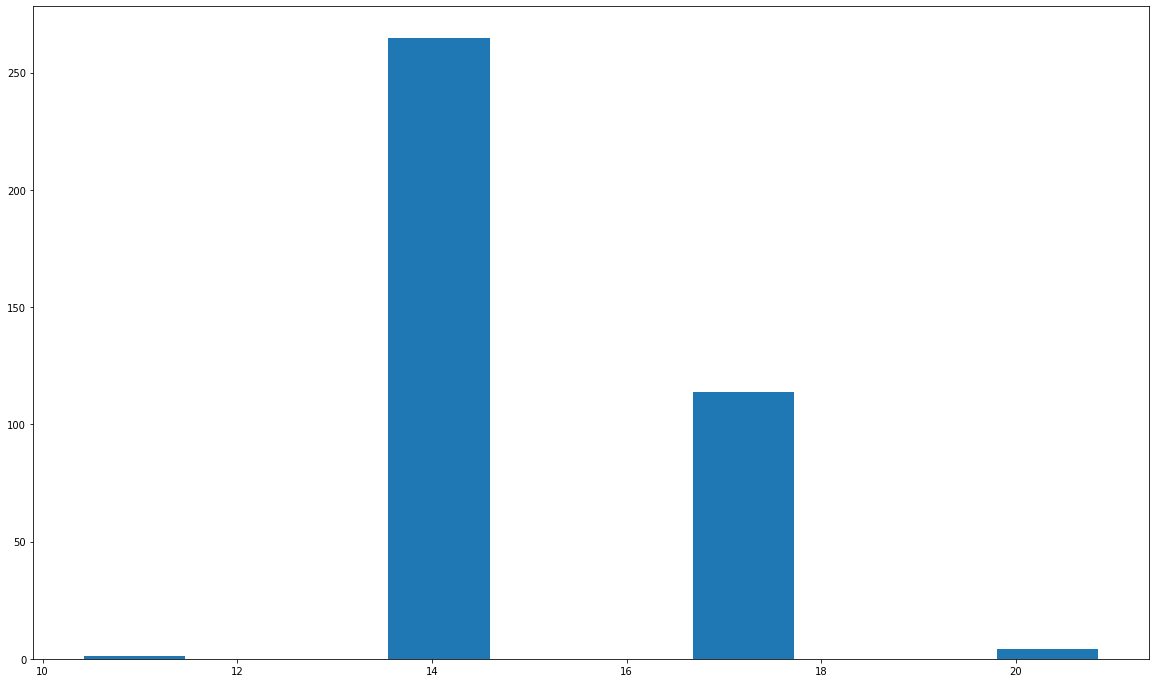

In [11]:
noise_levels_scaled = si.get_noise_levels(rec_preprocessed, return_scaled=True)

fig, ax = plt.subplots()
ax.hist(noise_levels_scaled)


In [12]:
noise_levels = si.get_noise_levels(rec_preprocessed, return_scaled=False)
noise_levels
print(np.mean(noise_levels), noise_levels.shape)

6.397485791944651 (384,)


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
        265.,   0.,   0., 114.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
        11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5]),
 <BarContainer object of 29 artists>)

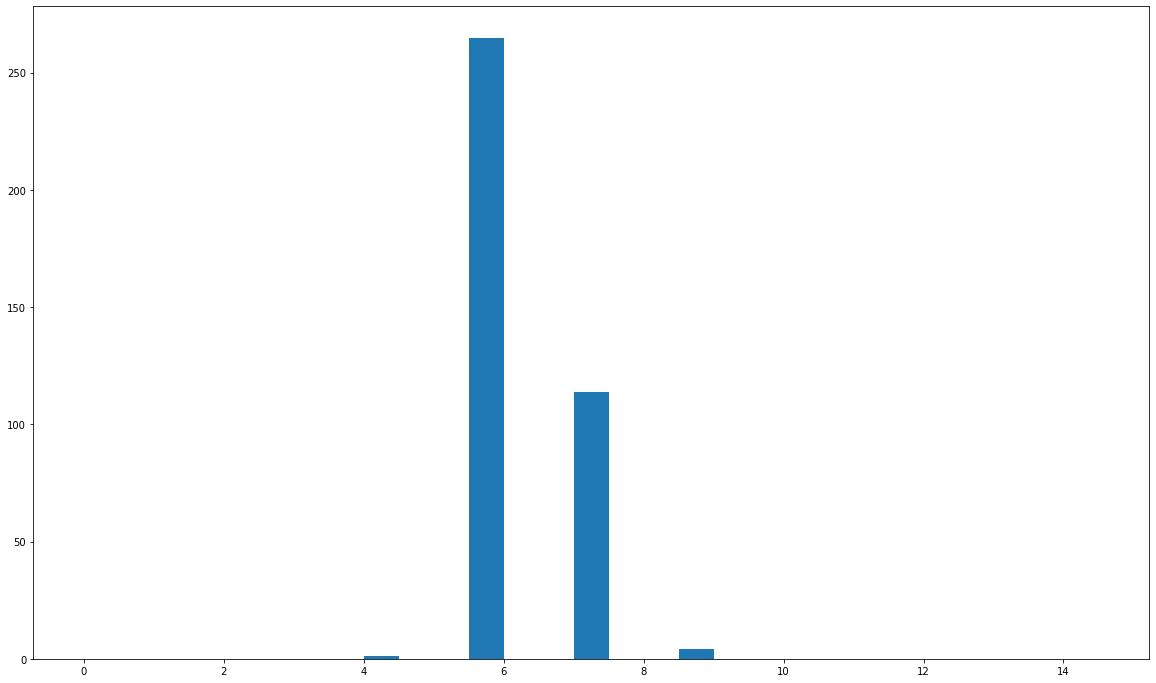

In [13]:
fig, ax = plt.subplots()
ax.hist(noise_levels, bins=np.arange(0, 15, .5))


## detect peaks

This take 1min30s

In [14]:
from spikeinterface.sortingcomponents import detect_peaks

In [15]:
peaks = detect_peaks(rec_preprocessed, method='locally_exclusive', local_radius_um=50,
                 peak_sign='neg', detect_threshold=5, n_shifts=5,
                 noise_levels=noise_levels, **job_kwargs)
np.save(peak_folder / 'peaks.npy', peaks)

detect peaks: 100%|██████████| 8944/8944 [33:47<00:00,  4.41it/s]  


In [16]:
# load back
peaks = np.load(peak_folder / 'peaks.npy')
print(peaks.shape)
peaks

(1957226,)


array([(        6,  77, -37., 0), (       54, 363, -38., 0),
       (      124,  89, -52., 0), ..., (116442567, 369, -33., 0),
       (116442591,  20, -38., 0), (116442591,  83, -31., 0)],
      dtype=[('sample_ind', '<i8'), ('channel_ind', '<i8'), ('amplitude', '<f8'), ('segment_ind', '<i8')])

## localize peaks

We use 2 methods:
  * 'center_of_mass': 9 s
  * 'monopolar_triangulation' : 26min

In [17]:
from spikeinterface.sortingcomponents import localize_peaks

In [18]:
peak_locations = localize_peaks(rec_preprocessed, peaks, 
                   ms_before=0.3, ms_after=0.6,
                   method='center_of_mass', method_kwargs={'local_radius_um': 100.},
                   **job_kwargs)
np.save(peak_folder / 'peak_locations_center_of_mass.npy', peak_locations)
print(peak_locations.shape)

localize peaks: 100%|██████████| 8944/8944 [22:35<00:00,  6.60it/s] 


(1957226,)


In [25]:
peak_locations = localize_peaks(rec_preprocessed, peaks,
                   ms_before=0.3, ms_after=0.6,
                   method='monopolar_triangulation', method_kwargs={'local_radius_um': 100., 'max_distance_um': 1000.},
                   **job_kwargs)
np.save(peak_folder / 'peak_locations_monopolar_triangulation.npy', peak_locations)
print(peak_locations.shape)

localize peaks: 100%|██████████| 4849/4849 [01:27<00:00, 55.56it/s]


(217540,)


In [19]:
# load back
peak_locations = np.load(peak_folder / 'peak_locations_center_of_mass.npy')
# peak_locations = np.load(peak_folder / 'peak_locations_monopolar_triangulation.npy')
print(peak_locations)
print(peak_locations.dtype)

[(26.18181818,  756.5967366 ) (24.37627812, 3624.5398773 )
 (30.34210526,  881.94078947) ... (25.75784753, 3681.07623318)
 (24.08648649,  200.48648649) (23.81920904,  814.40677966)]
[('x', '<f8'), ('y', '<f8')]


## plot peak on probe

(1500.0, 2500.0)

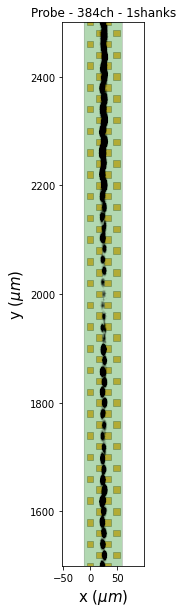

In [20]:
probe = rec_preprocessed.get_probe()

fig, ax = plt.subplots(figsize=(15, 10))
plot_probe(probe, ax=ax)
ax.scatter(peak_locations['x'], peak_locations['y'], color='k', s=1, alpha=0.02)
# ax.set_ylim(2400, 2900)
ax.set_ylim(1500, 2500)

## plot peak depth vs time

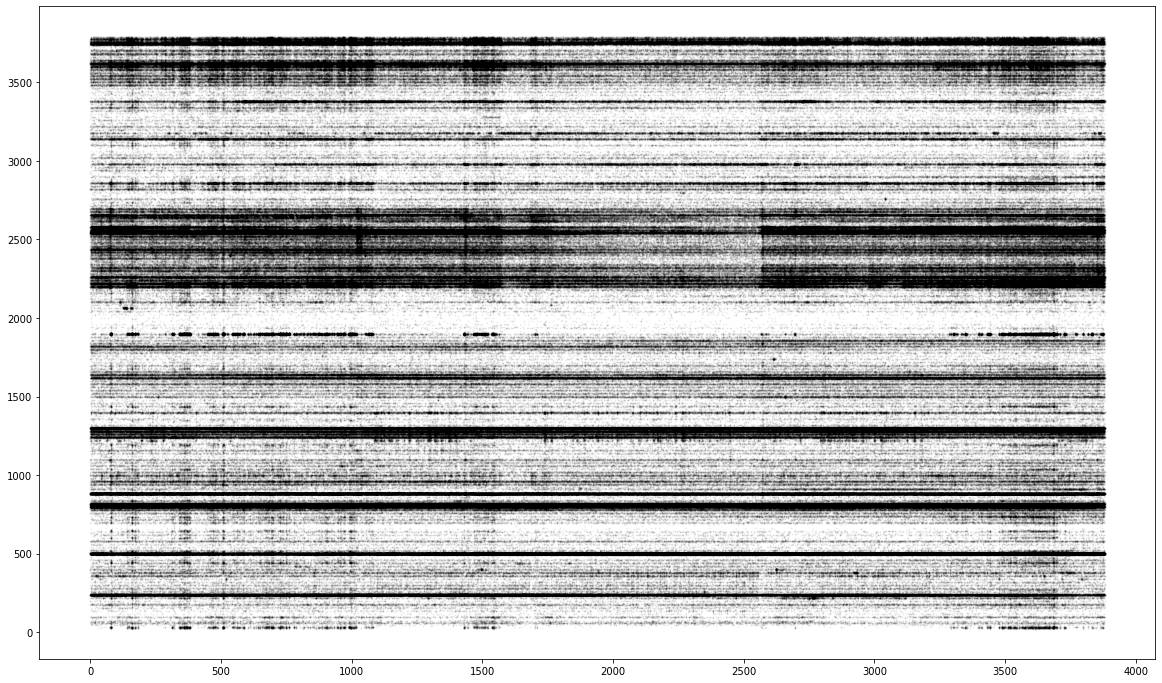

In [29]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
# ax.set_ylim(1300, 2500)

fig.savefig(peak_folder / 'CoM_motion_raster.png')

## motion estimate : rigid with decentralized

In [22]:
from spikeinterface.sortingcomponents import (estimate_motion, make_motion_histogram,
    compute_pairwise_displacement, compute_global_displacement)

In [23]:
bin_um = 2
bin_duration_s=5.

motion_histogram, temporal_bins, spatial_bins = make_motion_histogram(rec_preprocessed, peaks,
    peak_locations=peak_locations, 
    bin_um=bin_um, bin_duration_s=bin_duration_s,
    direction='y', weight_with_amplitude=False)
print(motion_histogram.shape, temporal_bins.size, spatial_bins.size)


(777, 1960) 778 1961


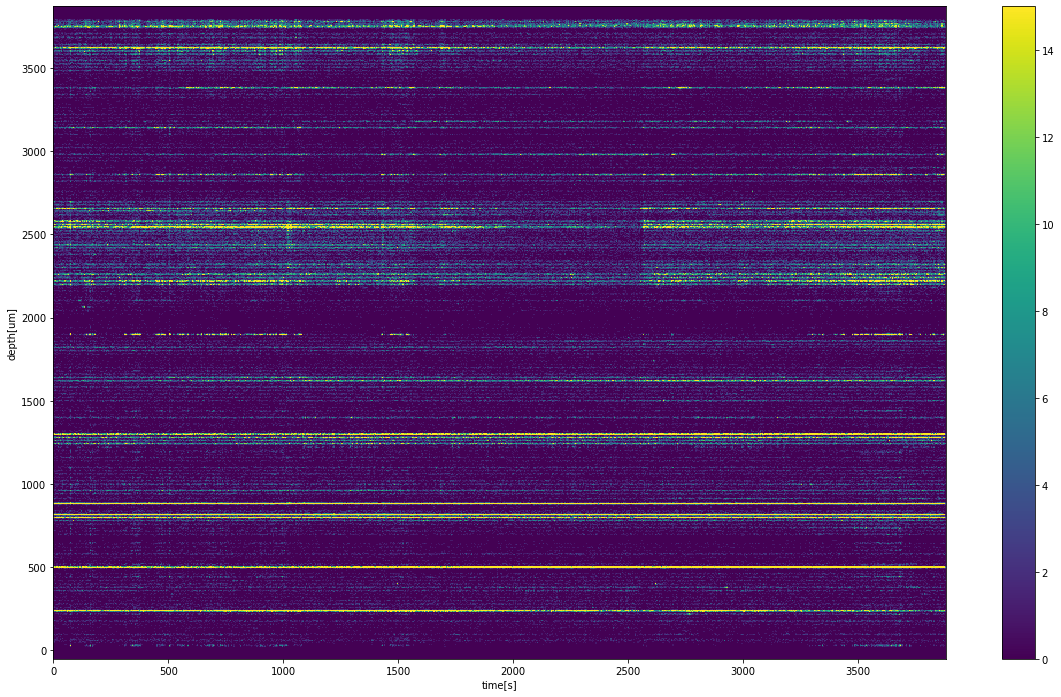

In [40]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], spatial_bins[0], spatial_bins[-1])
im = ax.imshow(motion_histogram.T, interpolation='nearest',
                    origin='lower', aspect='auto', extent=extent)
im.set_clim(0, 15)
# ax.set_ylim(1300, 2500)
ax.set_xlabel('time[s]')
ax.set_ylabel('depth[um]')

fig.colorbar(im)
fig.savefig(peak_folder / 'CoM_motion_histogram.png')

## plot one bins of histogram

150
[0. 0. 0. ... 0. 0. 0.]


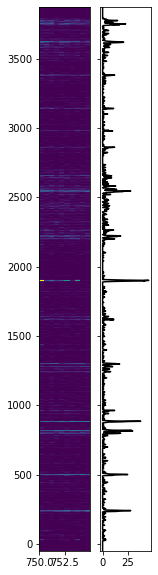

In [32]:
t = 750.
ind = np.argmin(np.abs(temporal_bins - t))
print(ind)
h = motion_histogram[ind, :]
print(h)

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(2,10))
extent = (temporal_bins[ind], temporal_bins[ind+1], spatial_bins[0], spatial_bins[-1])
im = axs[0].imshow(motion_histogram[ind-5:ind+5, :].T, interpolation='nearest',
                    origin='lower', aspect='auto', extent=extent)

axs[1].plot(h, spatial_bins[:-1], color='k')
fig.savefig(peak_folder / 'CoM_histogram_peak_along_depth_750.png')

# motion_histogram, temporal_bins, spatial_bins




## pariwise displacement from the motion histogram


In [33]:
pairwise_displacement = compute_pairwise_displacement(motion_histogram, bin_um, method='conv2d', progress_bar=True)
np.save(peak_folder / 'CoM_pairwise_displacement_conv2d.npy', pairwise_displacement)


100%|██████████| 777/777 [05:11<00:00,  2.49it/s]


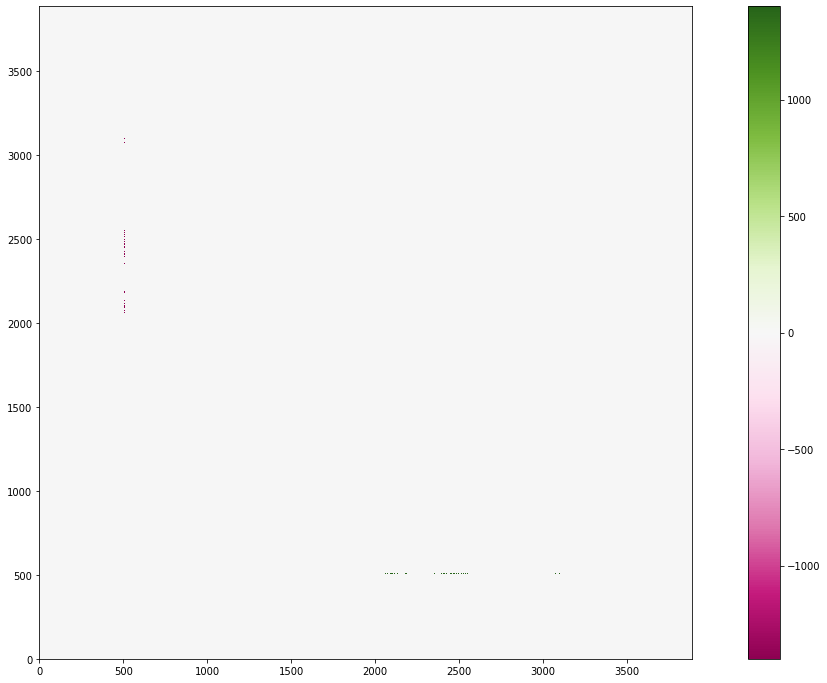

In [41]:
fig, ax = plt.subplots()
extent = (temporal_bins[0], temporal_bins[-1], temporal_bins[0], temporal_bins[-1])
# extent = None
im = ax.imshow(pairwise_displacement, interpolation='nearest',
                    cmap='PiYG', origin='lower', aspect='auto', extent=extent)
#im.set_clim(-40, 30)
ax.set_aspect('equal')
fig.colorbar(im)
fig.savefig(peak_folder / 'CoM_pairwise_displacement.png')

## estimate motion (rigid) from the pariwise discplaement

In [37]:
motion = compute_global_displacement(pairwise_displacement)

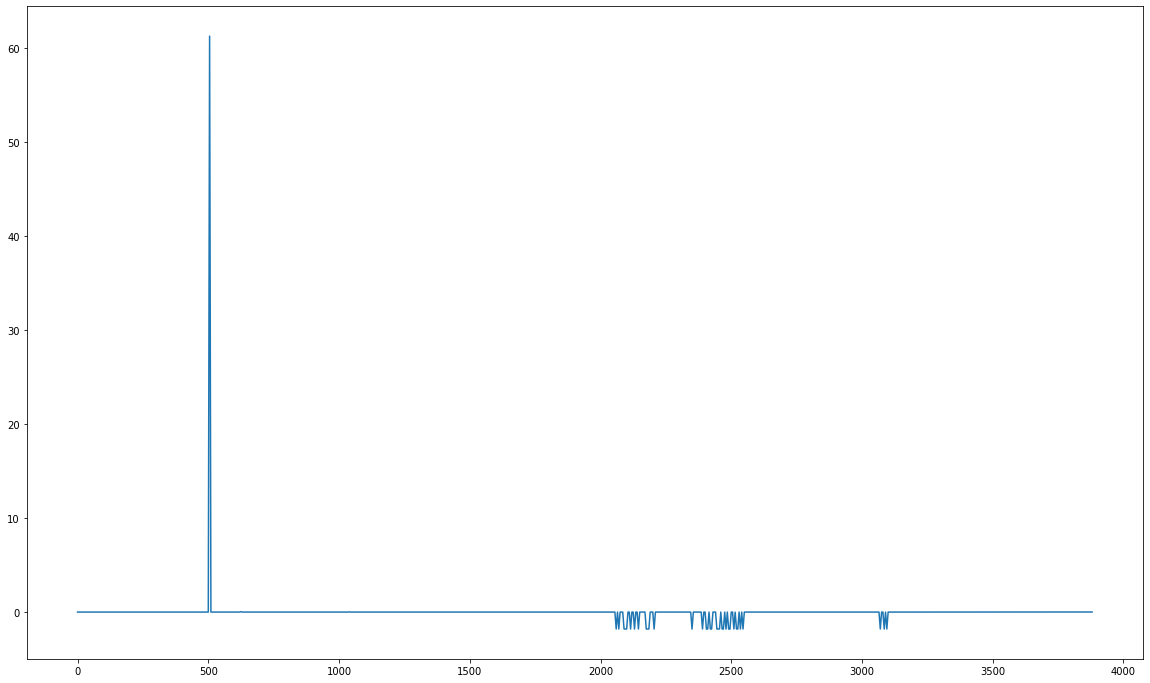

In [39]:
fig, ax = plt.subplots()
ax.plot(temporal_bins[:-1], motion)
fig.savefig(peak_folder / 'CoM_motion_esmiated_rigid.png')


## motion estimation with one unique funtion

Internanly `estimate_motion()` do:
  * make_motion_histogram()
  * compute_pairwise_displacement()
  * compute_global_displacement()
  

In [42]:
motion, temporal_bins, spatial_bins = estimate_motion(rec_preprocessed, peaks, peak_locations=peak_locations,
                    direction='y', bin_duration_s=5., bin_um=10.,
                    method='decentralized_registration', method_kwargs={},
                    non_rigid_kwargs=None, 
                    progress_bar=True, verbose=True)

np.save(peak_folder / 'CoM_motion_rigid.npy', motion)
np.save(peak_folder / 'CoM_temporal_bins_rigid.npy', temporal_bins)


Computing motion histogram
Computing pairwise displacement: 1 / 1


100%|██████████| 777/777 [00:24<00:00, 31.88it/s]
/home/e4/Python-related/GitHub/spikeinterface/spikeinterface/sortingcomponents/motion_estimation.py:265: RuntimeWarning: invalid value encountered in true_divide
  p += 2 * (np.sum(D - np.diag(D), axis=1) - (size - 1) * p) / np.linalg.norm(mat_norm)


Computing global displacement: 1 / 1


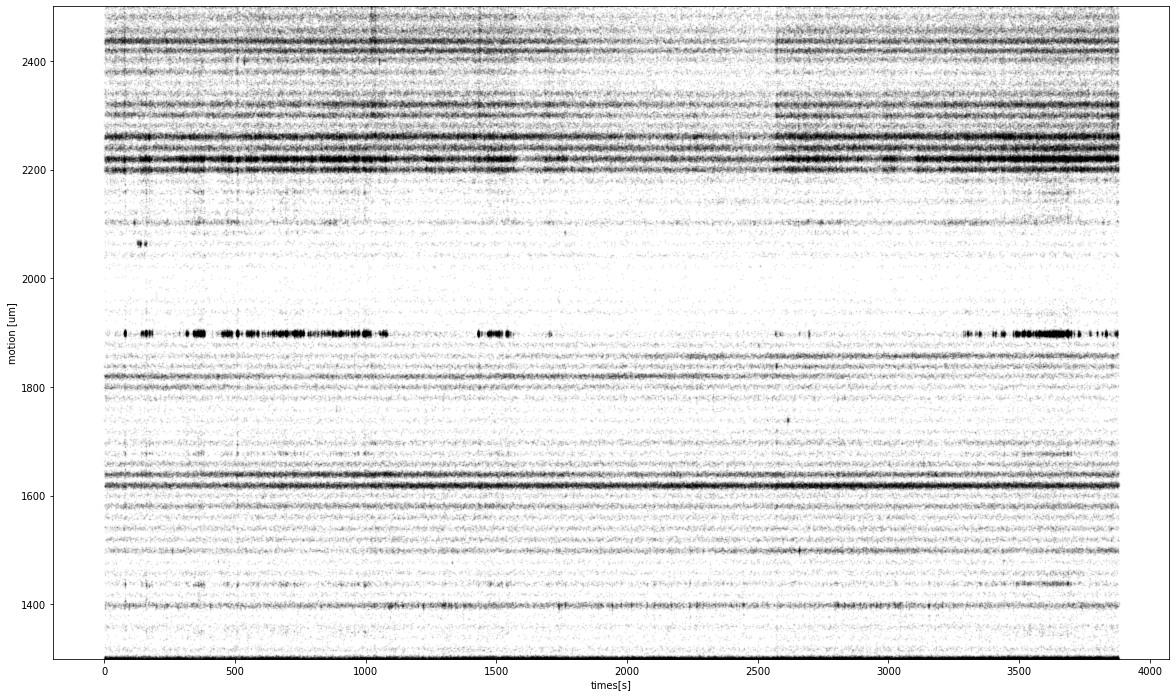

In [43]:
fig, ax = plt.subplots()
x = peaks['sample_ind'] / rec_preprocessed.get_sampling_frequency()
y = peak_locations['y']
ax.scatter(x, y, s=1, color='k', alpha=0.05)
ax.set_ylim(1300, 2500)


ax.plot(temporal_bins[:-1], motion + 2000, color='r')
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
fig.savefig(peak_folder / 'CoM_glob_rigid.png')

## motion estimation non rigid

In [44]:
motion, temporal_bins, spatial_bins = estimate_motion(rec_preprocessed, peaks, peak_locations=peak_locations,
                    direction='y', bin_duration_s=5., bin_um=10.,
                    method='decentralized_registration', method_kwargs={},
                    non_rigid_kwargs=dict(bin_step_um=100),
                    progress_bar=True, verbose=False)

np.save(peak_folder / 'CoM_motion_non_rigid.npy', motion)
np.save(peak_folder / 'CoM_temporal_bins_non_rigid.npy', temporal_bins)
np.save(peak_folder / 'CoM_spatial_bins_non_rigid.npy', spatial_bins)


 34%|███▍      | 265/777 [00:08<00:16, 30.67it/s]

Text(0, 0.5, 'motion [um]')

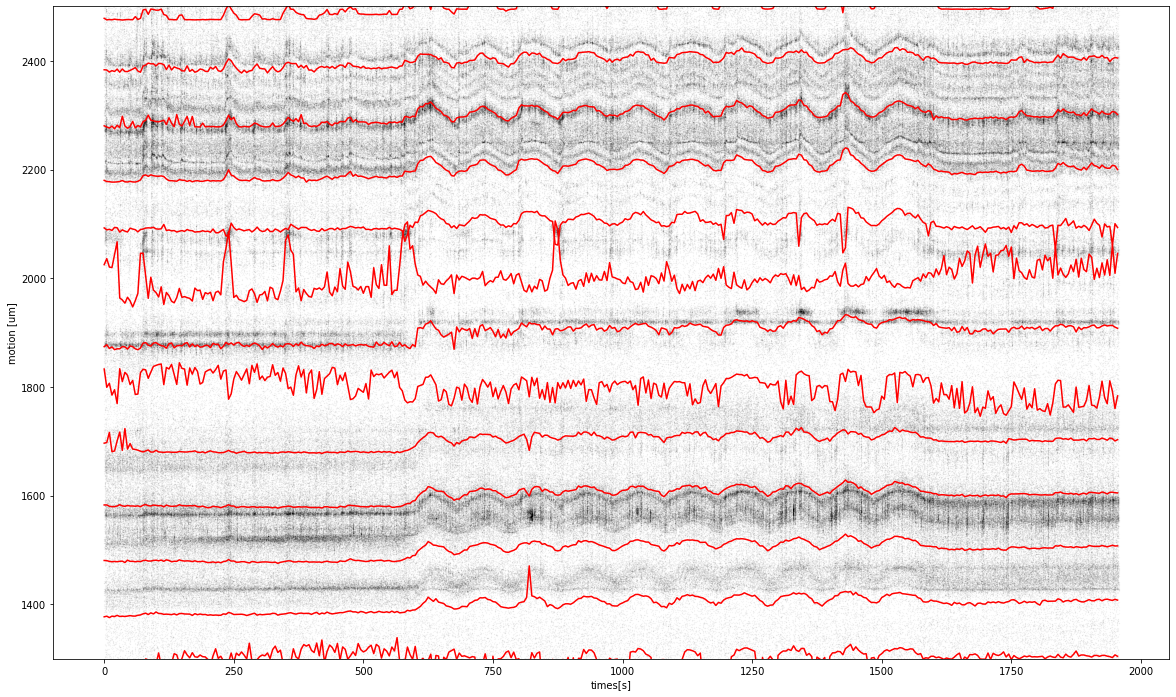

In [ ]:
fs = rec_preprocessed.get_sampling_frequency()

fig, ax = plt.subplots()
ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', s=0.1, alpha=0.05)


for i, s_bins in enumerate(spatial_bins):
     # several motion vector
     ax.plot(temporal_bins[:-1], motion[:, i] + spatial_bins[i], color='r')

ax.set_ylim(1300, 2500)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')

## correct **rigid** motion on peak location

In [65]:
from spikeinterface.sortingcomponents import correct_motion_on_peaks, correct_motion_on_traces

In [69]:
motion = np.load(peak_folder / 'motion_rigid.npy')
temporal_bins = np.load(peak_folder / 'temporal_bins_rigid.npy')
spatial_bins = None

In [75]:
times = rec_preprocessed.get_times()
corrected_peak_locations_rigid = correct_motion_on_peaks(peaks, peak_locations, times,
        motion, temporal_bins, spatial_bins,
        direction='y')

(1300.0, 2500.0)

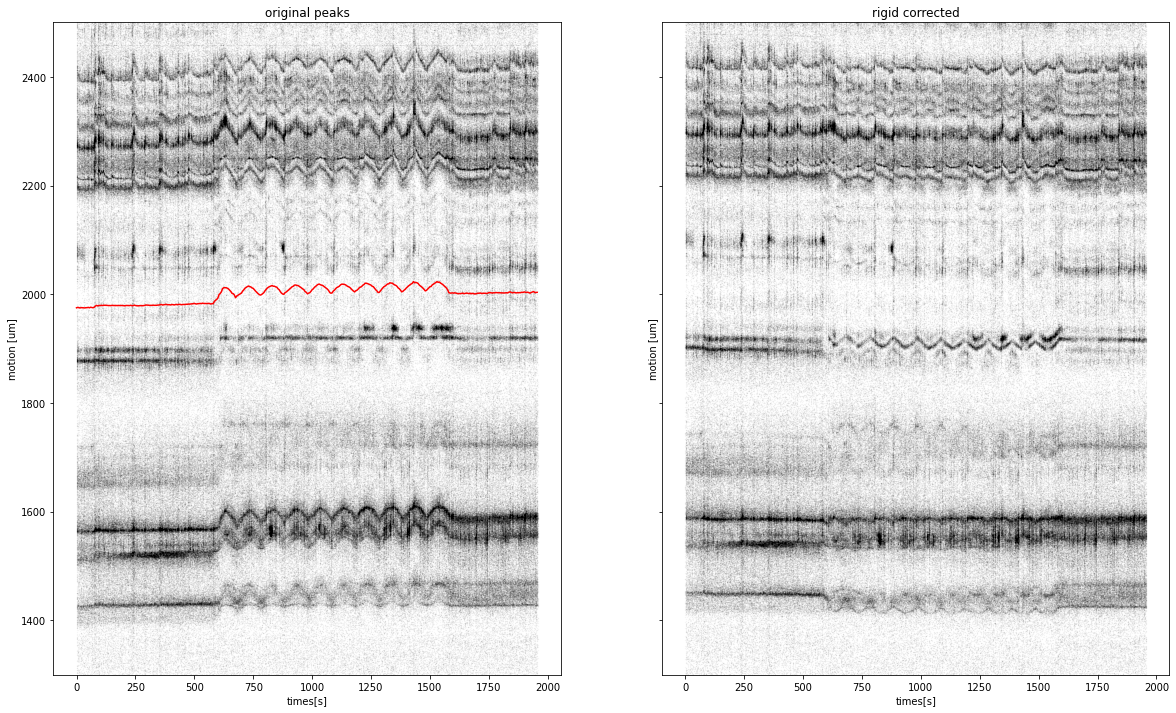

In [76]:
fs = rec_preprocessed.get_sampling_frequency()

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

ax = axs[0]
ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', s=0.1, alpha=0.05)
# ax.set_ylim(1300, 2500)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('original peaks')

av_depth = 2000 # for plotting
ax.plot(temporal_bins[:-1], motion + av_depth, color='r')

ax = axs[1]
ax.scatter(peaks['sample_ind'] / fs, corrected_peak_locations_rigid['y'], color='k', s=0.1, alpha=0.05)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('rigid corrected')

ax.set_ylim(1300, 2500)


## correct **non rigid** motion on peak location

In [77]:
motion = np.load(peak_folder / 'motion_non_rigid.npy')
temporal_bins = np.load(peak_folder / 'temporal_bins_non_rigid.npy')
spatial_bins = np.load(peak_folder / 'spatial_bins_non_rigid.npy')

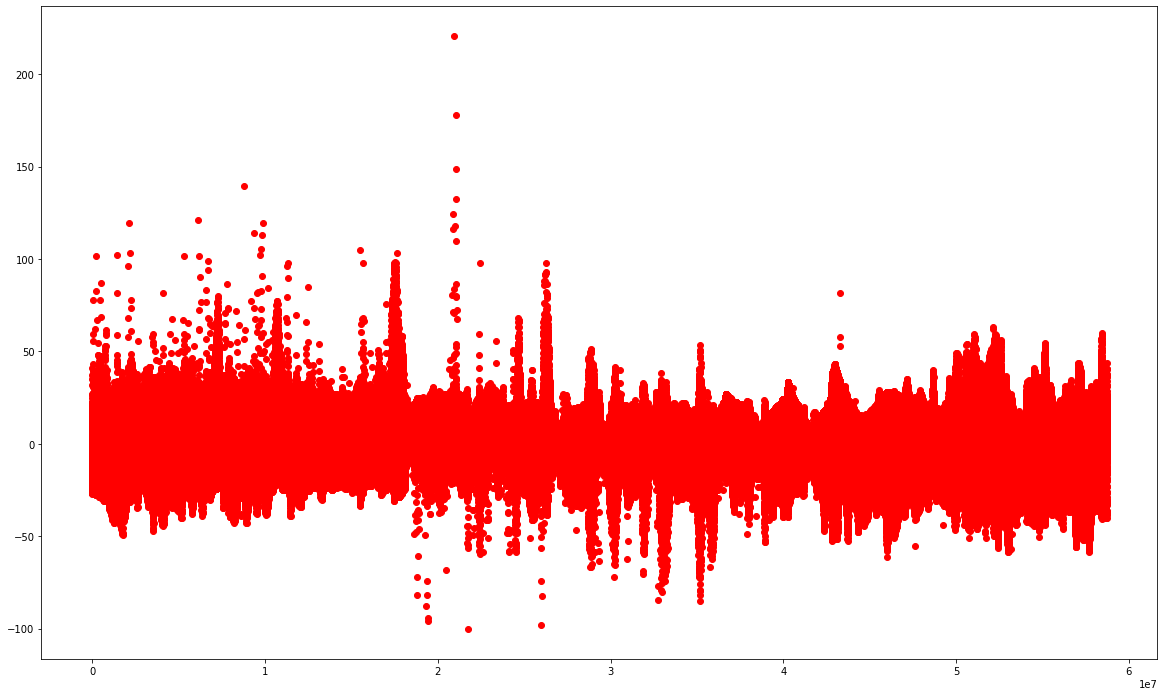

In [89]:
times = rec_preprocessed.get_times()
corrected_peak_locations_non_rigid = correct_motion_on_peaks(peaks, peak_locations, times,
        motion, temporal_bins, spatial_bins,
        direction='y', progress_bar=True)

(1300.0, 2500.0)

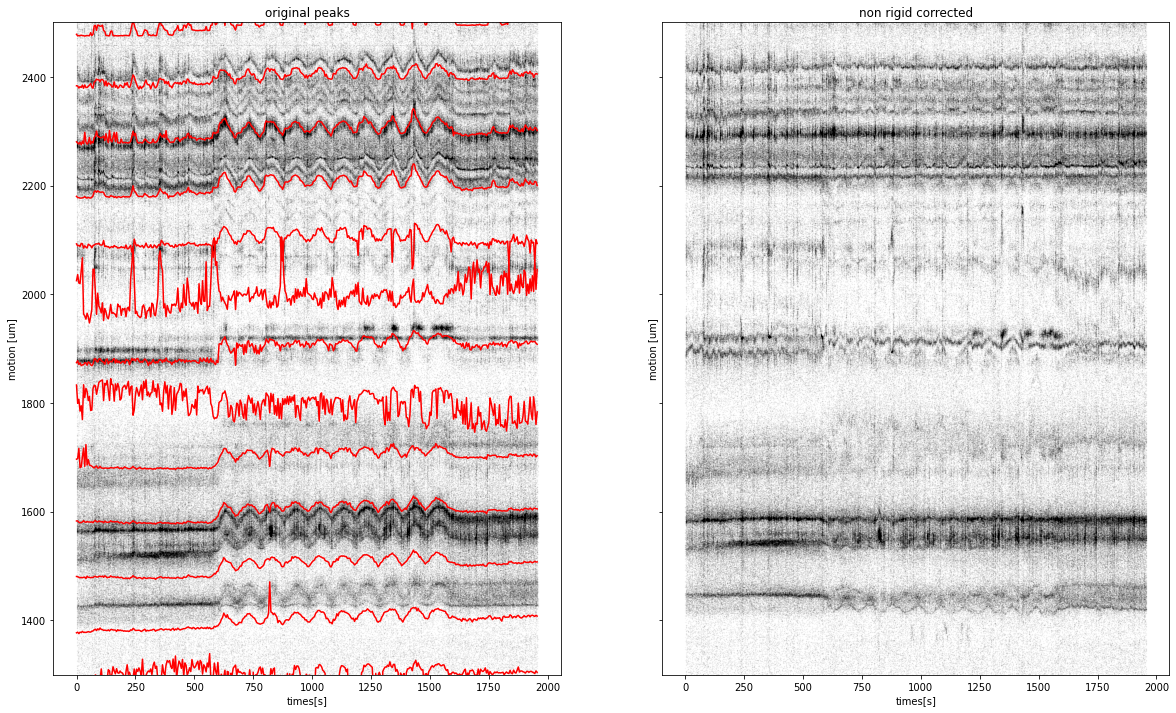

In [88]:
fs = rec_preprocessed.get_sampling_frequency()

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

ax = axs[0]
ax.scatter(peaks['sample_ind'] / fs, peak_locations['y'], color='k', s=0.1, alpha=0.05)
# ax.set_ylim(1300, 2500)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('original peaks')

for i, s_bins in enumerate(spatial_bins):
     ax.plot(temporal_bins[:-1], motion[:, i] + spatial_bins[i], color='r')

ax = axs[1]
ax.scatter(peaks['sample_ind'] / fs, corrected_peak_locations_non_rigid['y'], color='k', s=0.1, alpha=0.05)
ax.set_xlabel('times[s]')
ax.set_ylabel('motion [um]')
ax.set_title('non rigid corrected')

ax.set_ylim(1300, 2500)